In [2]:
import obspy
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.dates as dates
from scipy.signal import correlate
from scipy.stats.stats import pearsonr

in_dir = '../../data/banner/infrasound/out/'

In [4]:
# l = os.listdir(in_dir)
l = glob(os.path.join(in_dir, 'c0be4*'))
r = []
for i in l:
    i = os.path.basename(i)
    j = i[5:11]
    if j not in r:
        r.append(j)
r.sort()
dec = [i for i in r if i[2:4] == '12']
jan = [i for i in r if i[2:4] == '01']
pre_snow =[i for i in dec if int(i[-2:]) < 10]
post_snow =[i for i in dec if int(i[-2:]) > 12]
tonga = [i for i in jan if int(i[-2:]) > 14]
tonga = [i for i in tonga if int(i[-2:]) < 18]

In [5]:
r

['211202',
 '211203',
 '211204',
 '211205',
 '211206',
 '211207',
 '211209',
 '211211',
 '211214',
 '211215',
 '211216',
 '211217',
 '211218',
 '211219',
 '211220',
 '211221',
 '211222',
 '211223',
 '211224',
 '211225',
 '211226',
 '211227',
 '211228',
 '211229',
 '211230',
 '211231',
 '220101',
 '220102',
 '220103',
 '220104',
 '220105',
 '220106',
 '220107',
 '220108',
 '220109',
 '220110',
 '220111',
 '220112',
 '220113',
 '220114',
 '220115',
 '220116',
 '220117',
 '220118',
 '220119',
 '220120',
 '220121',
 '220122',
 '220123',
 '220124',
 '220125',
 '220126',
 '220127',
 '220128',
 '220129',
 '220130',
 '220131',
 '220201',
 '220202',
 '220203',
 '220204']

In [9]:
## From: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

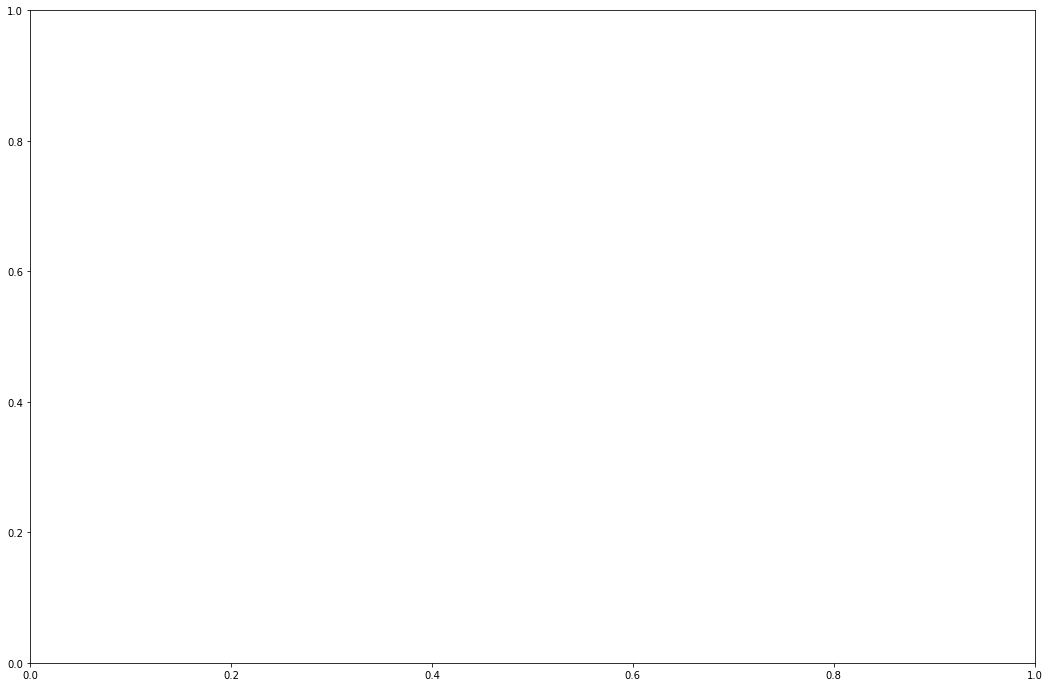

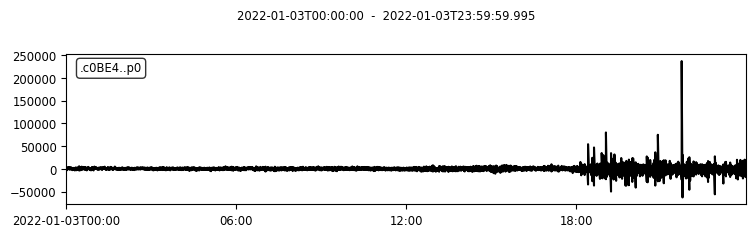

In [16]:
f, ax = plt.subplots(1,1, figsize = (18,12))
for d in ['220103']:
    st = obspy.Stream()
    # a += 1
    # if a == 3 or a == 4:
    for i, f in enumerate(glob(os.path.join(in_dir, f'c0be4{d}*'), recursive= True)):
        st += obspy.read(os.path.join(f))
        st.detrend("constant")
        #st.filter(type = 'bandpass', freqmin = 1.0, freqmax = 20.0)
    st = st.merge(method = 1)
    tr1 = st.select(channel = 'p0')[0]
    tr1.plot()

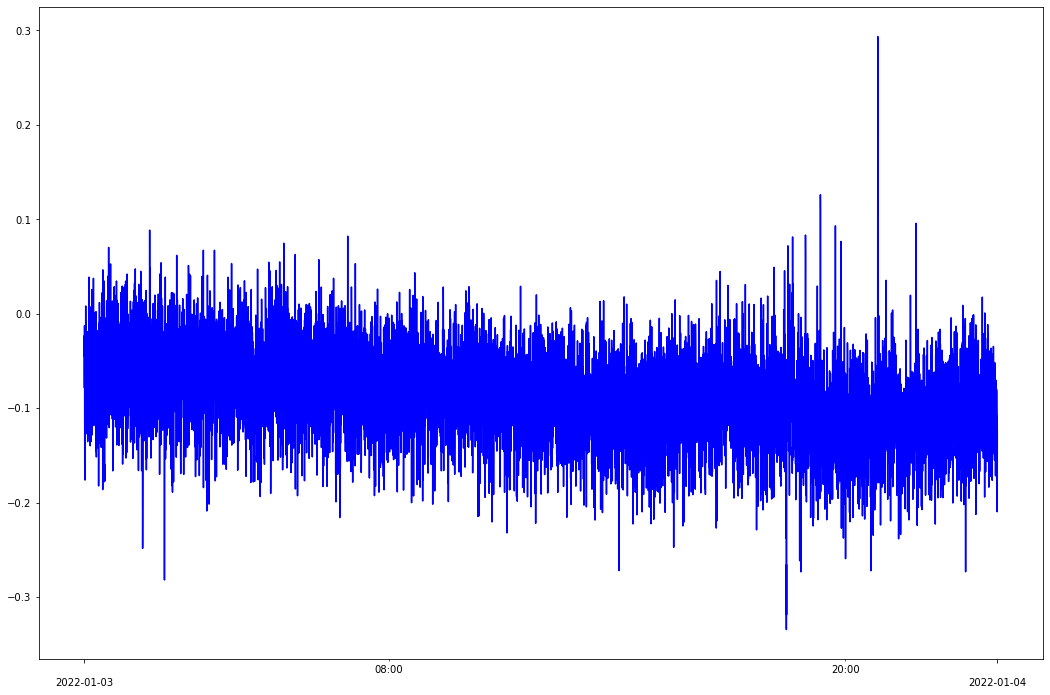

In [17]:
f, ax = plt.subplots(1,1, figsize = (18,12))
for d in ['220103']:
    st = obspy.Stream()
    # a += 1
    # if a == 3 or a == 4:
    for i, f in enumerate(glob(os.path.join(in_dir, f'c0be4{d}*'), recursive= True)):
        st += obspy.read(os.path.join(f))
        st.detrend("constant")
        #st.filter(type = 'bandpass', freqmin = 1.0, freqmax = 20.0)
    st = st.merge(method = 1)
    tr1 = st.select(channel = 'p0')[0]
    sps = tr1.__dict__['stats']['sampling_rate'] #samples per second
    
    wind = 10*sps #seconds of window
    ac_calib = 8.2928e-05
    order = 6
    #print(f'Samples per window: {wind}')
    arr1 = tr1.data * ac_calib
    arr1 = butter_bandpass_filter(arr1, 1, 20, sps, order= order)

    if int(len(arr1)/wind) == len(arr1)/wind:
        
        tr2 = st.select(channel = 'p2')[0]
        arr2 = tr2.data * ac_calib
        arr2 = butter_bandpass_filter(arr2, 3, 20, sps, order= order)
        arr1 = np.reshape(arr1, (int(wind),int(len(arr1)/wind)), 'F')
        #arr2 = arr2.reshape(-1, int(wind))
        arr2 = np.reshape(arr2, (int(wind),int(len(arr2)/wind)), 'F')

        # now compute Pearson
        xcorr0lag = np.sum(arr1*arr2, axis = 0)
        #xcorr0lag = sum(arr1*arr2)
        normalization = np.sqrt(np.sum(arr1**2, axis = 0)*np.sum(arr2**2, axis = 0))
        Pcoeff = xcorr0lag/normalization
        
        # p = a*b
        # n = np.sqrt(np.sum(a**2)*np.sum(b**2))
        # print(p/n)
        # np.mean(p/n, axis = 1)
        # # Pcoeff = np.corrcoef(arr1, arr2)

        start = pd.to_datetime(tr1.__dict__['stats']['starttime'].datetime)
        end = pd.to_datetime(tr1.__dict__['stats']['endtime'].datetime)
        t = np.linspace(start.value, end.value, len(Pcoeff))
        t = pd.to_datetime(t)
        plt.plot(t, Pcoeff, color = 'blue')
ax.xaxis.set_minor_locator(dates.HourLocator(interval=12))   # every 4 hours
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
ax.xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%Y-%m-%d')) 


 ...]

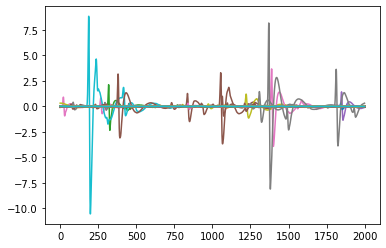

In [13]:
plt.plot(arr1)